In [34]:
import zipfile
import io
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [35]:
tf.__version__

'2.15.0'

In [36]:
zip_file_path = '/content/drive/MyDrive/archive.zip'
# Open the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all contents to a folder
    zip_ref.extractall('extracted_contents')

# List the extracted files
extracted_files = zip_ref.namelist()
print("Extracted files:", extracted_files)

Extracted files: ['111J8.jpg', '111XM.jpg', '113EV.jpg', '113dk.jpg', '113sB.jpg', '114ty.jpg', '115rB.jpg', '116OC.jpg', '116gw.jpg', '119bg.jpg', '11AWu.jpg', '11AvS.jpg', '11Cbx.jpg', '11CgC.jpg', '11D8l.jpg', '11DXU.jpg', '11EB7.jpg', '11FI9.jpg', '11GdB.jpg', '11Iwb.jpg', '11OTg.jpg', '11OUZ.jpg', '11RKd.jpg', '11U9a.jpg', '11VFv.jpg', '11Vmh.jpg', '11XrW.jpg', '11Ydw.jpg', '11YpK.jpg', '11ZJB.jpg', '11Zch.jpg', '11bav.jpg', '11ePW.jpg', '11ePd.jpg', '11g54.jpg', '11gIZ.jpg', '11kL8.jpg', '11lOX.jpg', '11nW8.jpg', '11pDK.jpg', '11q3M.jpg', '11rUA.jpg', '11rbg.jpg', '11rqV.jpg', '11uyC.jpg', '11xqY.jpg', '11zhw.jpg', '11zkc.jpg', '125un.jpg', '12Agx.jpg', '12E8r.jpg', '12Gyu.jpg', '12JXR.jpg', '12KzM.jpg', '12Lgp.jpg', '12LsN.jpg', '12MEk.jpg', '12NuE.jpg', '12OJ9.jpg', '12Q9a.jpg', '12SY7.jpg', '12WFp.jpg', '12cgs.jpg', '12fk4.jpg', '12gWd.jpg', '12iis.jpg', '12m3v.jpg', '12qx3.jpg', '12rDE.jpg', '12tEF.jpg', '12vKa.jpg', '12w4j.jpg', '12xjG.jpg', '1319f.jpg', '133xl.jpg', '1349p.

In [37]:
# Path to the Dataset
path = Path("/content/extracted_contents")

dir_img = sorted(list(map(str, list(path.glob("*.jpg")))))
img_labels = [img.split(os.path.sep)[-1].split(".jpg")[0] for img in dir_img]
char_img = set(char for label in img_labels for char in label)
char_img = sorted(list(char_img))

print("Number of dir_img found: ", len(dir_img))
print("Number of img_labels found: ", len(img_labels))
print("Number of unique char_img: ", len(char_img))
print("Characters present: ", char_img)

# Batch Size of Training and Validation
batch_size = 16

# Setting dimensions of the image
img_width = 150
img_height = 40

# Setting downsampling factor
downsample_factor = 4

# Setting the Maximum Length
max_length = max([len(label) for label in img_labels])

# Char to integers
char_to_num = layers.StringLookup(
	vocabulary=list(char_img), mask_token=None
)

# Integers to original chaecters
num_to_char = layers.StringLookup(
	vocabulary=char_to_num.get_vocabulary(),
	mask_token=None, invert=True
)


Number of dir_img found:  113062
Number of img_labels found:  113062
Number of unique char_img:  60
Characters present:  ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [38]:
dir_img[:10]

['/content/extracted_contents/111J8.jpg',
 '/content/extracted_contents/111XM.jpg',
 '/content/extracted_contents/113EV.jpg',
 '/content/extracted_contents/113dk.jpg',
 '/content/extracted_contents/113sB.jpg',
 '/content/extracted_contents/114ty.jpg',
 '/content/extracted_contents/115rB.jpg',
 '/content/extracted_contents/116OC.jpg',
 '/content/extracted_contents/116gw.jpg',
 '/content/extracted_contents/119bg.jpg']

In [39]:
img_labels[:10]

['111J8',
 '111XM',
 '113EV',
 '113dk',
 '113sB',
 '114ty',
 '115rB',
 '116OC',
 '116gw',
 '119bg']

In [40]:
def data_split(dir_img, img_labels,
			train_size=0.9, shuffle=True):
	# Get the total size of the dataset
	size = len(dir_img)
	# Create an indices array and shuffle it if required
	indices = np.arange(size)
	if shuffle:
		np.random.shuffle(indices)
	# Calculate the size of training samples
	train_samples = int(size * train_size)
	# Split data into training and validation sets
	x_train, y_train = dir_img[indices[:train_samples]], img_labels[indices[:train_samples]]
	x_valid, y_valid = dir_img[indices[train_samples:]], img_labels[indices[train_samples:]]
	return x_train, x_valid, y_train, y_valid


# Split data into training and validation sets
x_train, x_valid, y_train, y_valid = data_split(np.array(dir_img), np.array(img_labels))


def encode_sample(img_path, label):
	# Read the image
	img = tf.io.read_file(img_path)
	# Converting the image to grayscale
	img = tf.io.decode_png(img, channels=1)
	img = tf.image.convert_image_dtype(img, tf.float32)
	# Resizing to the desired size
	img = tf.image.resize(img, [img_height, img_width])
	# Transposing the image
	img = tf.transpose(img, perm=[1, 0, 2])
	# Mapping image label to numbers
	label = char_to_num(tf.strings.unicode_split(label,
												input_encoding="UTF-8"))

	return {"image": img, "label": label}


In [41]:
# Creating training dataset
dataset_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset_train = (
	dataset_train.map(
		encode_sample, num_parallel_calls=tf.data.AUTOTUNE
	)
	.batch(batch_size)
	.prefetch(buffer_size=tf.data.AUTOTUNE)
)


# Creating validation dataset
val_data = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
val_data = (
	val_data.map(
		encode_sample, num_parallel_calls=tf.data.AUTOTUNE
	)
	.batch(batch_size)
	.prefetch(buffer_size=tf.data.AUTOTUNE)
)


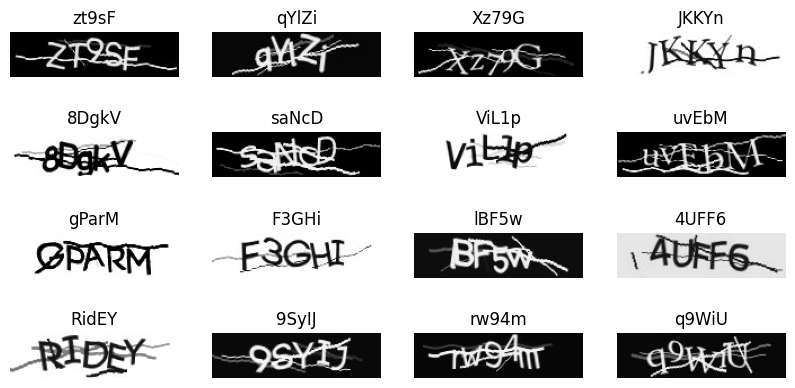

In [42]:
# Visualizing some training data
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in dataset_train.take(1):
	dir_img = batch["image"]
	img_labels = batch["label"]
	for i in range(16):
		img = (dir_img[i] * 255).numpy().astype("uint8")
		label = tf.strings.reduce_join(num_to_char(
			img_labels[i])).numpy().decode("utf-8")
		ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
		ax[i // 4, i % 4].set_title(label)
		ax[i // 4, i % 4].axis("off")
plt.show()

In [43]:
# CTC loss calculation
class LayerCTC(layers.Layer):
	def __init__(self, name=None):
		super().__init__(name=name)
		self.loss_fn = keras.backend.ctc_batch_cost

	def call(self, y_true, y_pred):
		# Compute the training-time loss value
		batch_len = tf.cast(tf.shape(y_true)[0],
							dtype="int64")
		input_length = tf.cast(tf.shape(y_pred)[1],
							dtype="int64")
		label_length = tf.cast(tf.shape(y_true)[1],
							dtype="int64")

		input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
		label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

		loss = self.loss_fn(y_true, y_pred,
							input_length, label_length)
		self.add_loss(loss)

		# Return Computed predictions
		return y_pred


def model_build():
	# Define the inputs to the model
	input_img = layers.Input(
		shape=(img_width, img_height, 1),
		name="image", dtype="float32"
	)
	img_labels = layers.Input(name="label",
							shape=(None,),
							dtype="float32")

	# First convolutional block
	x = layers.Conv2D(
		32,
		(3, 3),
		activation="relu",
		kernel_initializer="he_normal",
		padding="same",
		name="Conv1",
	)(input_img)
	x = layers.MaxPooling2D((2, 2), name="pool1")(x)

	# Second convolutional block
	x = layers.Conv2D(
		64,
		(3, 3),
		activation="relu",
		kernel_initializer="he_normal",
		padding="same",
		name="Conv2",
	)(x)
	x = layers.MaxPooling2D((2, 2), name="pool2")(x)

	# Reshaping the output before passing to RNN
	new_shape = ((img_width // 4), (img_height // 4) * 64)
	x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
	x = layers.Dense(64, activation="relu", name="dense1")(x)
	x = layers.Dropout(0.2)(x)

	# RNNs
	x = layers.Bidirectional(layers.LSTM(
		128, return_sequences=True, dropout=0.25))(x)
	x = layers.Bidirectional(layers.LSTM(
		64, return_sequences=True, dropout=0.25))(x)

	# Output layer
	x = layers.Dense(
		len(char_to_num.get_vocabulary()) + 1,
		activation="softmax", name="dense2"
	)(x)

	# Calculate CTC loss at each step
	output = LayerCTC(name="ctc_loss")(img_labels, x)

	# Defining the model
	model = keras.models.Model(
		inputs=[input_img, img_labels],
		outputs=output,
		name="ocr_model_v1"
	)
	opt = keras.optimizers.Adam()

	# Compile the model
	model.compile(optimizer=opt)

	return model

In [44]:
# Build the model
model = model_build()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 150, 40, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 150, 40, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 75, 20, 32)           0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 75, 20, 64)           18496     ['pool1[0][0]']               
                                                                                       

In [45]:
# Early Stopping Parameters and EPOCH
epochs = 5 #Increase it to increase the accuracy
early_stopping_patience = 10

early_stopping = keras.callbacks.EarlyStopping(
	monitor="val_loss",
	patience=early_stopping_patience,
	restore_best_weights=True
)

# Training the model
history = model.fit(
	dataset_train,
	validation_data=val_data,
	epochs=epochs,
	callbacks=[early_stopping],
)

Epoch 1/5
6360/6360 [==============================] - 208s 31ms/step - loss: 20.8514 - val_loss: 18.6944
Epoch 2/5
6360/6360 [==============================] - 183s 29ms/step - loss: 16.3616 - val_loss: 13.4199
Epoch 3/5
6360/6360 [==============================] - 187s 29ms/step - loss: 12.4478 - val_loss: 10.0174
Epoch 4/5
6360/6360 [==============================] - 181s 28ms/step - loss: 10.0991 - val_loss: 8.0504
Epoch 5/5
6360/6360 [==============================] - 183s 29ms/step - loss: 8.6145 - val_loss: 6.7201


In [46]:
# Get the Model
prediction_model = keras.models.Model(
	model.get_layer(name="image").input,
	model.get_layer(name="dense2").output
)
prediction_model.summary()


def decode_batch_predictions(pred):
	input_len = np.ones(pred.shape[0]) * pred.shape[1]
	results = keras.backend.ctc_decode(pred,
									input_length=input_len,
									greedy=True)[0][0][
		:, :max_length
	]
	output_text = []
	for res in results:
		res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
		output_text.append(res)
	return output_text

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 150, 40, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 150, 40, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 75, 20, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 75, 20, 64)        18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 37, 10, 64)        0         
                                                                 
 reshape (Reshape)           (None, 37, 640)           0         
                                                                 
 dense1 (Dense)              (None, 37, 64)            4102

1/1 [==============================] - 1s 1s/step


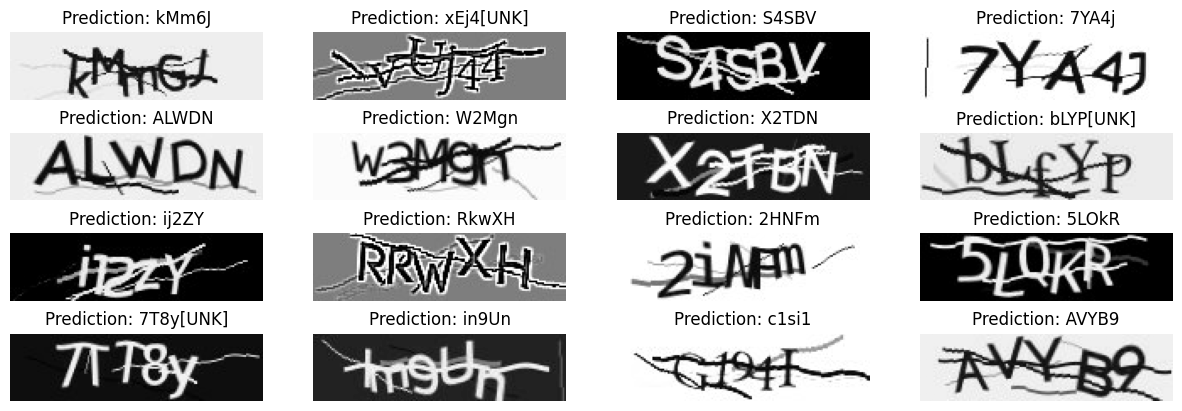

In [47]:
# Check the validation on a few samples
for batch in val_data.take(1):
	batch_images = batch["image"]
	batch_labels = batch["label"]


	preds = prediction_model.predict(batch_images)
	pred_texts = decode_batch_predictions(preds)


	orig_texts = []
	for label in batch_labels:
		label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
		orig_texts.append(label)


	_, ax = plt.subplots(4, 4, figsize=(15, 5))
	for i in range(len(pred_texts)):
		img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
		img = img.T
		title = f"Prediction: {pred_texts[i]}"
		ax[i // 4, i % 4].imshow(img, cmap="gray")
		ax[i // 4, i % 4].set_title(title)
		ax[i // 4, i % 4].axis("off")
plt.show()